Starting point: https://cloud.google.com/blog/products/gcp/intro-to-text-classification-with-keras-automatically-tagging-stack-overflow-posts

In [251]:
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

# Data, data, data

We have 5000 StackOverflow posts that have only one tag. We want to use the post to predict what the tag is.

In [226]:
raw_data = pd.read_csv('../data/stackOverflow.csv')
raw_data.head(10)

,post,tag
0,getting absolute path of directory how do i g...,python
1,css page header/colours show up in safari but...,css
2,position absolute is not within the relative p...,css
3,extracting individual items resulting from a s...,python
4,resizable backgrounds ok i need to make a who...,css
5,why aren t these two divs displayed how i expe...,html
6,strange height size top menu in my top menu f...,css
7,what is the space between these elements wha...,html
8,javascript missing semicolon so i am using j...,javascript
9,how can we link a html button i would like t...,html


In [227]:
raw_data.tag.unique()

array(['python', 'css', 'html', 'javascript', 'jquery'], dtype=object)

The tag words probably often occur in the posts, so let's strip them out to make things a bit more challenging.

In [228]:
data = raw_data.copy()
tags = data.tag.unique()

def tag_stripper(s):
    return ' '.join(filter((lambda w: w not in tags), s.split()))

data['post'] = data.post.apply(tag_stripper)

In [229]:
data.head(10)

,post,tag
0,getting absolute path of directory how do i ge...,python
1,page header/colours show up in safari but not ...,css
2,position absolute is not within the relative p...,css
3,extracting individual items resulting from a s...,python
4,resizable backgrounds ok i need to make a whol...,css
5,why aren t these two divs displayed how i expe...,html
6,strange height size top menu in my top menu fo...,css
7,what is the space between these elements what ...,html
8,missing semicolon so i am using jsfiddle.net t...,javascript
9,how can we link a button i would like to creat...,html


### How long are the posts?

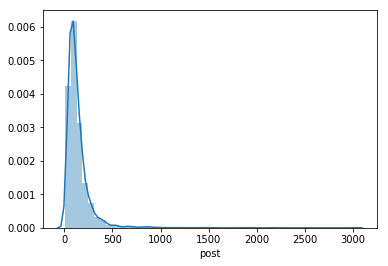

In [230]:
post_lengths = data.post.apply(lambda s: len(s.split()))
sns.distplot(post_lengths)

In [231]:
post_lengths.describe()

count    5000.00000
mean      138.53200
std       139.37451
min         8.00000
25%        68.00000
50%       105.00000
75%       162.00000
max      3019.00000
Name: post, dtype: float64

So the average length of the posts in 139 words, with half the posts having less than 105 words.

### Split into training data and testing data

It is **crucial** that we test our classifier using data that was **not** used to build. We split the data into two chunks, the data used to train (ie. build) the classifier, and the data we will later use to test it.

In [232]:
train_data = data[:4000]
test_data = data[4000:]
print(f"Training on {len(train_data)} rows")
print(f"Testing on {len(test_data)} rows")

Training on 4000 rows
Testing on 1000 rows


# Build a classifier!

### Convert posts to word counts

We will use a **bag of words** approach. Here we ignore what the posts mean, and we even ignore the order of the words in the post. (!) All that matters is the number of times each word appears.

We convert the words into numbers, and the posts into vectors of word counts.

In [233]:
vectorizer = CountVectorizer()
word_counts = vectorizer.fit_transform(train_data.post)

In [234]:
print(f"Number of words in the training data: {len(vectorizer.get_feature_names())}")
print(f"first 10: {', '.join(vectorizer.get_feature_names()[:10])}")
print(f"middle 10: {', '.join(vectorizer.get_feature_names()[13000:13010])}")

Number of words in the training data: 26878
first 10: 00, 000, 0000, 00000, 000000, 0000000, 000000000, 00001, 0000121593475342, 000016
middle 10: ideal, ideally, idealy, ideas, ident, identical, identically, identifications, identified, identifier


Lets look at the first post.

In [235]:
print(f" tag: {train_data.tag.tolist()[0]}")
print(f"post: {train_data.post.tolist()[0]}")

 tag: python
post: getting absolute path of directory how do i get the absolute path of a directory (it has to be any directory not the current one!) in i tried with <code>os.path.listdir()</code> but it yields only the relative one. thanks!


In [236]:
word_counts[0]

<1x26878 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

This tells us that there are 26878 different words in the training data. The first post has 28 different words. We encode it as a sparse vector rather than one that's almost all zeros.

In [237]:
print(word_counts[0])

  (0, 23915)	1
  (0, 20271)	1
  (0, 17659)	1
  (0, 26612)	1
  (0, 5930)	1
  (0, 15095)	1
  (0, 17903)	1
  (0, 6946)	2
  (0, 26169)	1
  (0, 24558)	1
  (0, 13266)	1
  (0, 17627)	2
  (0, 7983)	1
  (0, 17186)	1
  (0, 4309)	1
  (0, 5159)	1
  (0, 24237)	1
  (0, 12420)	1
  (0, 13925)	2
  (0, 23923)	3
  (0, 11721)	1
  (0, 9133)	1
  (0, 12803)	1
  (0, 8914)	3
  (0, 17515)	2
  (0, 18367)	3
  (0, 3495)	2
  (0, 11901)	1


In [238]:
vectorizer.get_feature_names()[8914]

'directory'

### Naively classifying

Our classifier will have two steps. First we convert the data into word counts as above. Then we use these word counts in a Naive Bayes classifier. 

This is pretty much the simplest classifier we can use. It has few parameters but makes lots of assumptions about the data that are totally wrong. 

For example, it assumes that the words appear independently, ie one word appearing in a post doesn't change the likelihood of one of the other words appearing.

Since our posts are sentences, this is really wrong.

In [239]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [240]:
predictions = classifier.predict(test_data.post)
print(f"Average chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")
print("Not terrible!")

Average chance that a prediction is correct: 73%
Not terrible!


A **confusion matrix** shows us how many things got classified as other things.

In [241]:
row_index = pd.MultiIndex.from_tuples([('actual', x) for x in tags])
col_index = pd.MultiIndex.from_tuples([('predicted', x) for x in tags])
confusion_matrix = metrics.confusion_matrix(test_data.tag, predictions)

df = pd.DataFrame(confusion_matrix, index=row_index, columns=col_index)
df['Count'] = df[df.columns].sum(axis=1)
s = df.sum()
s.name = ('actual', "Count")
df = df.append(s)

confusion_matrix_4000 = df
confusion_matrix_4000

predicted                             Count
                     python  css html javascript jquery      
actual python           162   23    6          8      3   202
       css               35  112   15         24     19   205
       html               6   13  138         28     23   208
       javascript         4   16   37        133      5   195
       jquery             2    0    4          0    184   190
       Count            209  164  200        193    234  1000

What if we don't have much data?

In [242]:
train_data = data[:100]
test_data = data[4000:]
print(f"Training on {len(train_data)} rows")
print(f"Testing on {len(test_data)} rows")

Training on 100 rows
Testing on 1000 rows


In [246]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

classifier.fit(train_data.post, train_data.tag)
print(f"Previous chance that a prediction was correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")
predictions = classifier.predict(test_data.post)
print(f"      New chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")

Previous chance that a prediction was correct: 56%
      New chance that a prediction is correct: 56%


In [244]:
row_index = pd.MultiIndex.from_tuples([('actual', x) for x in tags])
col_index = pd.MultiIndex.from_tuples([('predicted', x) for x in tags])
confusion_matrix = metrics.confusion_matrix(test_data.tag, predictions)

df = pd.DataFrame(confusion_matrix, index=row_index, columns=col_index)
df['Count'] = df[df.columns].sum(axis=1)
s = df.sum()
s.name = ('actual', "Count")
df = df.append(s)

confusion_matrix_100 = df
confusion_matrix_100

predicted                             Count
                     python  css html javascript jquery      
actual python           153   31   16          1      1   202
       css               68   89   32          8      8   205
       html              10   17  163          7     11   208
       javascript        34   20   93         46      2   195
       jquery             0   16   63          1    110   190
       Count            265  173  367         63    132  1000

Really terrible at classifying javascript posts :(

In [245]:
confusion_matrix_4000

predicted                             Count
                     python  css html javascript jquery      
actual python           162   23    6          8      3   202
       css               35  112   15         24     19   205
       html               6   13  138         28     23   208
       javascript         4   16   37        133      5   195
       jquery             2    0    4          0    184   190
       Count            209  164  200        193    234  1000

#  Use a better classifier!

Let's try a slightly better classifier, a support vector machine.

In [248]:
train_data = data[:4000]
test_data = data[4000:]
print(f"Training on {len(train_data)} rows")
print(f"Testing on {len(test_data)} rows")

Training on 4000 rows
Testing on 1000 rows


In [252]:
classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=0.01)),
])

classifier.fit(train_data.post, train_data.tag)
predictions = classifier.predict(test_data.post)
print(f"      New chance that a prediction is correct: {np.mean(predictions == test_data.tag) * 100:.0f}%")


      New chance that a prediction is correct: 74%


/Users/sastels/.local/share/virtualenvs/racc-data-exploration-GfbU4NdO/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [253]:
row_index = pd.MultiIndex.from_tuples([('actual', x) for x in tags])
col_index = pd.MultiIndex.from_tuples([('predicted', x) for x in tags])
confusion_matrix = metrics.confusion_matrix(test_data.tag, predictions)

df = pd.DataFrame(confusion_matrix, index=row_index, columns=col_index)
df['Count'] = df[df.columns].sum(axis=1)
s = df.sum()
s.name = ('actual', "Count")
df = df.append(s)
df

predicted                             Count
                     python  css html javascript jquery      
actual python           157   33    1          8      3   202
       css               34  124   14         20     13   205
       html              12   17  126         32     21   208
       javascript         4    8   19        159      5   195
       jquery             4    4    1          6    175   190
       Count            211  186  161        225    217  1000

In [254]:
confusion_matrix_4000

predicted                             Count
                     python  css html javascript jquery      
actual python           162   23    6          8      3   202
       css               35  112   15         24     19   205
       html               6   13  138         28     23   208
       javascript         4   16   37        133      5   195
       jquery             2    0    4          0    184   190
       Count            209  164  200        193    234  1000

Not really better than Naive Bayes !